In [1]:
%matplotlib inline

In [2]:
from thetis import *

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [14]:
from adapt_utils.case_studies.tohoku.options.options import TohokuOptions, TohokuInversionOptions
from adapt_utils.plotting import *
from adapt_utils.swe.tsunami.conversion import lonlat_to_utm
from adapt_utils.unsteady.solver import AdaptiveProblem

Get zoom region

In [5]:
lonlat_corners = [(138, 32), (148, 42), (138, 42)]
utm_corners = [lonlat_to_utm(*corner, 54) for corner in lonlat_corners]
xlim = [utm_corners[0][0], utm_corners[1][0]]
ylim = [utm_corners[0][1], utm_corners[2][1]]

In [8]:
create_directory('plots')

'plots'

## Mesh

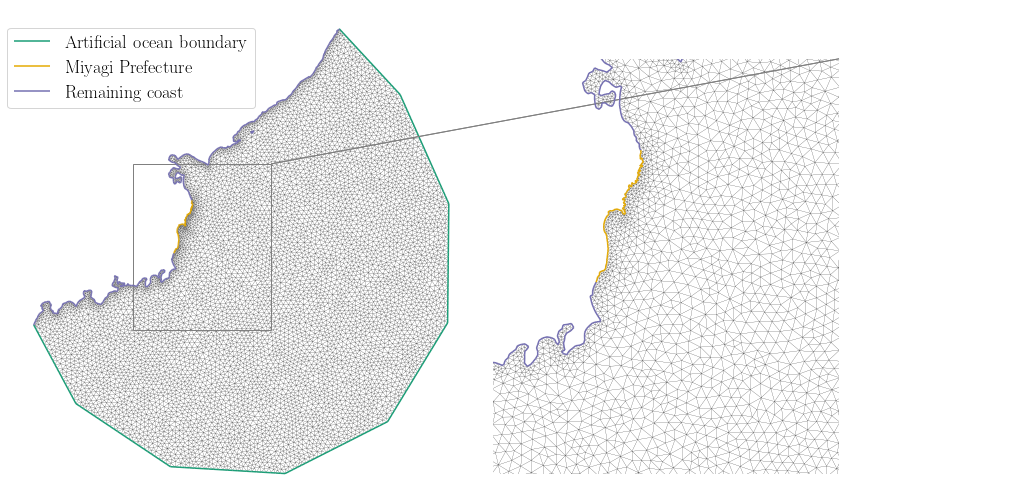

In [27]:
kwargs = {
    "interior_kw": {
        "linewidth": 0.1,
    },
#     "boundary_kw": {
#         "colors": ["C0", "C2", "C1"],
#     },
}

for level in [0]:
    
    op = TohokuOptions(level=level)

    # Plot whole mesh
    height = 9
    fig, axes = plt.subplots(ncols=2, figsize=(2*height, height))
    axes[1].axis(False);
    axes = axes[0]
    triplot(op.default_mesh, axes=axes, **kwargs);
    axes.axis(False);
    lines, labels = axes.get_legend_handles_labels()
    lines = [lines[0], lines[2], lines[1]]
    labels = ["Artificial ocean boundary", "Miyagi Prefecture", "Remaining coast"]
    legend = axes.legend(lines, labels, bbox_to_anchor=[0.55, 0.975], fontsize=18);

    # Add zoom
    axins = zoomed_inset_axes(axes, 2.5, bbox_to_anchor=[1000, 530]) # zoom-factor: 2.5
    triplot(op.default_mesh, axes=axins, **kwargs);
    axins.axis(False);
    axins.set_xlim(xlim);
    axins.set_ylim(ylim);
    mark_inset(axes, axins, loc1=1, loc2=1, fc="none", ec="0.5");

    # Save
#     plt.savefig('plots/mesh_{:d}.pdf'.format(level));
    plt.savefig('plots/mesh_{:d}.jpg'.format(level));
    if level != 0:
        plt.close()

## Bathymetry and gauges

In [15]:
op = TohokuInversionOptions(level=3)
P1 = FunctionSpace(op.default_mesh, "CG", 1)
bathymetry = op.set_bathymetry(P1)

/home/joe/software/firedrake-pragmatic/src/firedrake/firedrake/parloops.py:130: LoopyWarning: 'lang_version' was not passed to make_function(). To avoid this warning, pass lang_version=(2018, 2) in this invocation. (Or say 'from loopy.version import LOOPY_USE_LANGUAGE_VERSION_2018_2' in the global scope of the calling frame.)
  knl = loopy.make_function(kernel_domains, instructions, kargs, seq_dependencies=True,


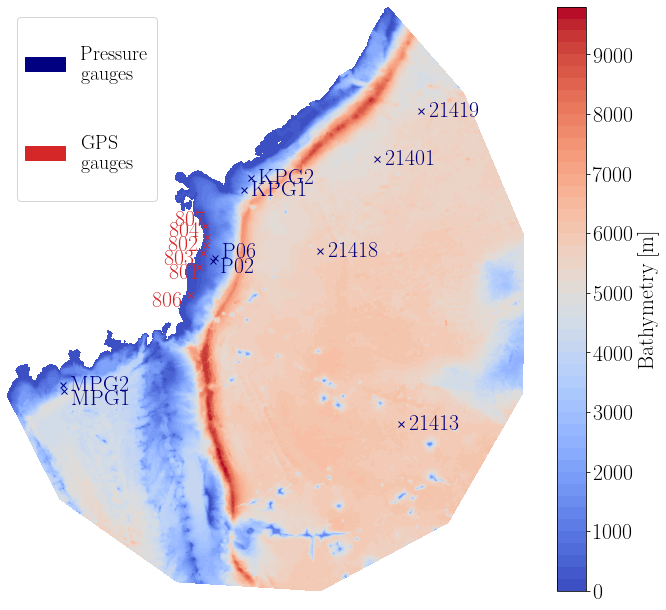

In [16]:
height = 9
fig, axes = plt.subplots(figsize=(height*1.1, height))
cmap = 'coolwarm'
cbar = fig.colorbar(tricontourf(bathymetry, levels=50, axes=axes, cmap=cmap), ax=axes);
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=22)
cbar.set_label('Bathymetry [m]', fontsize=22)
axes.axis(False);
op.annotate_plot(axes, fontsize=22)

# Custom legend
handles = [
    matplotlib.patches.Patch(color='navy', label='\nPressure\ngauges\n'),
    matplotlib.patches.Patch(color='C3', label='\nGPS\ngauges\n')
]
axes.legend(handles=handles, loc='upper left', fontsize=20);
plt.tight_layout()
# plt.savefig('plots/bathymetry_and_gauges.pdf');
plt.savefig('plots/bathymetry_and_gauges.jpg');

## Single Gaussian basis function

Used in 1D inversion experiments

In [17]:
from adapt_utils.case_studies.tohoku.options.radial_options import TohokuRadialBasisOptions

op = TohokuRadialBasisOptions(level=3, control_parameters=[1.0, ], nx=1, ny=1, family='cg-cg')
swp = AdaptiveProblem(op)
swp.set_initial_condition()
phi = swp.fwd_solutions[0].split()[1]

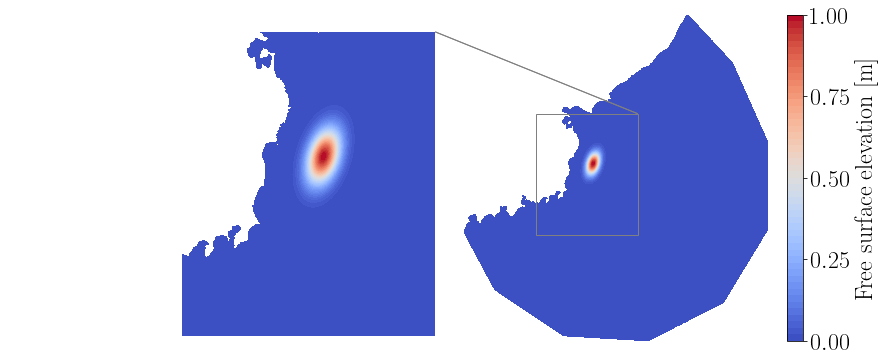

In [18]:
height = 6
figure, axes = plt.subplots(ncols=2, figsize=(2.5*height, height))
axes[0].axis(False);
axes = axes[1]

# Plot over whole domain
cbar = figure.colorbar(tricontourf(phi, levels=51, axes=axes, cmap='coolwarm'), ax=axes)
cbar.set_label(r"Free surface elevation $[\mathrm m]$");
cbar.set_ticks(np.linspace(0, 1, 5))
axes.axis(False);

# Add zoom
axins = zoomed_inset_axes(axes, 2.5, bbox_to_anchor=[575, 375]) # zoom-factor: 2.5
tricontourf(phi, levels=51, axes=axins, cmap='coolwarm');
axins.axis(False);
axins.set_xlim(xlim);
axins.set_ylim(ylim);
mark_inset(axes, axins, loc1=1, loc2=1, fc="none", ec="0.5");

# Save
# plt.savefig('plots/gaussian_basis_function.pdf')
plt.savefig('plots/gaussian_basis_function.jpg')

## Array of Gaussian basis functions

As used in the inversion experiments documented in [Saito et al. 2011].

In [11]:
from adapt_utils.case_studies.tohoku.options.radial_options import TohokuRadialBasisOptions

nx = 13
ny = 10

kwargs = {
    'level': 2,
    'control_parameters': 10*np.random.rand(nx*ny),
    'nx': nx,
    'ny': ny,
    'family': 'cg-cg',
}
op = TohokuRadialBasisOptions(**kwargs)
swp = AdaptiveProblem(op)
swp.set_initial_condition()
phi = swp.fwd_solutions[0].split()[1]

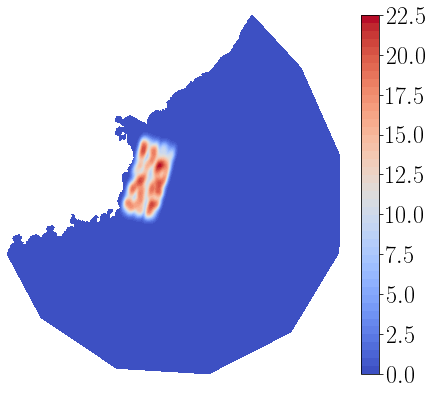

In [12]:
height = 6
figure, axes = plt.subplots(figsize=(height*1.1, height))
figure.colorbar(tricontourf(phi, levels=50, axes=axes, cmap='coolwarm'), ax=axes);
axes.axis(False);
plt.tight_layout()
# plt.savefig('plots/radial_basis_function_array.pdf')
# plt.savefig('plots/radial_basis_function_array.png')

## Array of rectangular indicator functions

The array has the same shape and size as the one above.

In [9]:
from adapt_utils.case_studies.tohoku.options.box_options import TohokuBoxBasisOptions

nx = 13
ny = 10
kwargs = {
    'level': 2,
    'control_parameters': 10*np.random.rand(nx*ny),
    'nx': nx,
    'ny': ny,
    'radius_x': 0.5*560.0e+03/nx,
    'radius_y': 0.5*240.0e+03/ny,
    'family': 'cg-cg',
}
op = TohokuBoxBasisOptions(**kwargs)
swp = AdaptiveProblem(op)
swp.set_initial_condition()
phi = swp.fwd_solutions[0].split()[1]

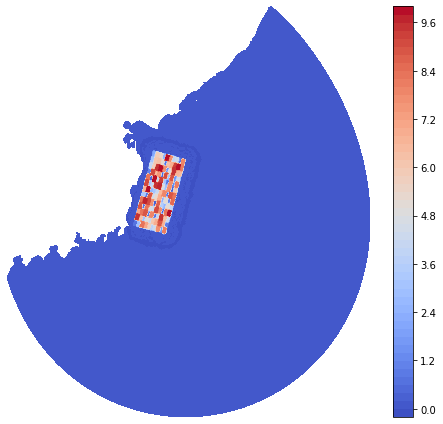

In [10]:
height = 6
figure, axes = plt.subplots(figsize=(height*1.1, height))
figure.colorbar(tricontourf(phi, levels=50, axes=axes, cmap='coolwarm'), ax=axes);
axes.axis(False);
plt.tight_layout()
# plt.savefig('plots/box_basis_function_array.pdf')
# plt.savefig('plots/box_basis_function_array.png')

## Array of Okada functions

Initial condition from [Shao et al. 2012], but with the ruptures considered as static rather than dynamic.

In [5]:
from adapt_utils.case_studies.tohoku.options.okada_options import TohokuOkadaOptions

kwargs = {
    'level': 2,
    'family': 'cg-cg',
}
op = TohokuOkadaOptions(**kwargs)
swp = AdaptiveProblem(op)
swp.set_initial_condition()
phi = swp.fwd_solutions[0].split()[1]

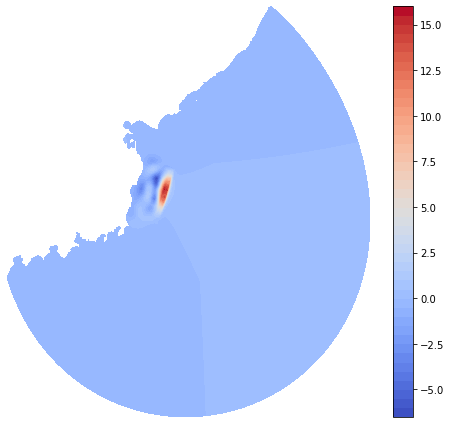

In [6]:
height = 6
figure, axes = plt.subplots(figsize=(height*1.1, height))
figure.colorbar(tricontourf(phi, levels=50, axes=axes, cmap='coolwarm'), ax=axes);
axes.axis(False);
plt.tight_layout()
# plt.savefig('plots/okada_array.pdf')
# plt.savefig('plots/okada_array.png')